<a href="https://colab.research.google.com/github/szeshiang/Deep-Learning/blob/main/11_06_Text_Classification_Using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification using BERT


## Steps to Be Followed:
1. Importing the required libraries for working with Bert and training a Bert-based model
2. Reading and previewing data from a CSV file using Pandas
3. Visualizing category distribution with a bar chart
4. Customizing dataset class for text classification with BERT tokenization
5. Fine-tuning BERT for text classification
6. Training and validation loop for BERT-based classifier
7. Implementing function for model evaluation
8. Splitting the dataset
9. Training the model
10. Evaluating the model

### Step 1: Importing the Required Libraries for Working with Bert and Training a Bert-Based Model
- Import pandas for data manipulation
- Import torch for tensor operations and neural networks
- Import NumPy for numerical operations
- Import BertTokenizer and BertModel from the transformers library for BERT-specific functionalities
- Import nn from torch for neural network components.
- Import Adam from torch.optim for the Adam optimizer
- Import tqdm for creating progress bars. These imports set up the required dependencies for working with BERT and training a BERT-based model

In [ ]:
!pip install transformers
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 128.3 MB/s eta 0:00:00


### Step 2: Reading and Previewing Data from a CSV File Using Pandas
- Read the CSV file into a DataFrame
- Display the first few rows of the DataFrame



In [ ]:
#datapath = f'/content/drive/My Drive/Medium/bbc-text.csv'
df = pd.read_csv("bbc-text.csv")
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


**Observation:**

The code reads a CSV file named **bbc-text.csv** from the specified path and displays the first few rows of the dataset.

### Step 3: Visualizing Category Distribution with a Bar Chart
- Group the DataFrame by category column and calculate the size of each group
- Plot a bar chart to visualize the group sizes



<Axes: xlabel='category'>

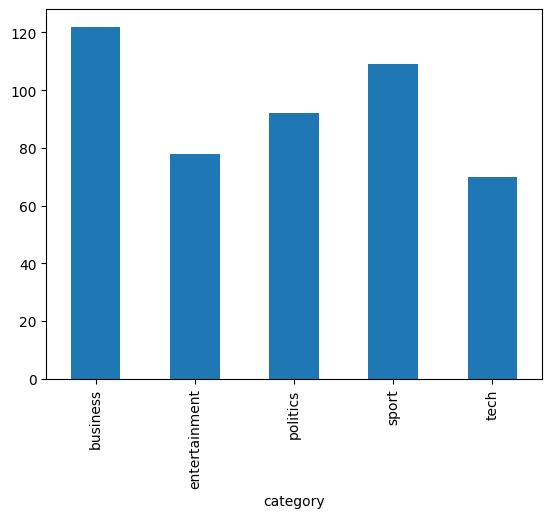

In [ ]:
df.groupby(['category']).size().plot.bar()

**Observation:**

The code snippet performs a groupby operation on the category column of the DataFrame df, calculates the size of each category group, and then creates a bar plot to visualize the distribution of categories.

### Step 4: Customizing Dataset Class for Text Classification with BERT Tokenization
- Initialize the tokenizer from the BERT model
- Define a dictionary to map category labels to numerical values
- Define a custom dataset class for text classification
- Map category labels to numerical values
- Tokenize and encode texts using the tokenizer
- Return the labels of the dataset
- Return the length of the dataset
- Fetch a batch of labels given an index
- Fetch a batch of tokenized texts given an index
- Retrieve a batch of tokenized texts and labels


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'business':0,
          'entertainment':1,
          'sport':2,
          'tech':3,
          'politics':4
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

**Observation:**

The code defines a custom dataset class for text classification using BERT tokenizer, mapping categories to numerical labels and providing methods to retrieve batches of tokenized texts and labels.

### Step 5: Fine-tuning BERT for Text Classification
- Define a PyTorch module for text classification using BERT as the base model
- Load the pre-trained BERT model
- Define a dropout layer with the specified dropout rate
- Define a linear layer with input size of 768 and output size of 5
- Define a ReLU activation function
- Perform forward pass through the BERT model
- Apply dropout to the pooled output
- Pass the dropout output through the linear layer
- Apply the ReLU activation function to the linear output



In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

### Step 6: Training and Validation Loop for BERT-based Classifier
- Create dataset objects and data loaders for training and validation data
- Check if CUDA is available and set the device accordingly
- Define the loss function and optimizer
- Move the model and loss function to CUDA if available
- The training loop iterates over the batches of training data. It moves the inputs and labels to the device, performs the forward pass through the model, calculates the batch loss and accuracy, performs the backward pass and optimization step, and updates the total loss and accuracy.

- Similarly, the validation loop iterates over the batches of validation data. It performs the forward pass, calculates the batch loss and accuracy, and updates the total loss and accuracy.
- Print epoch results


In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')


### Step 7: Implementing Function for Model Evaluation
- Evaluates the performance of a trained model on the provided test data
- Create a Dataset object using the test data
- Create a DataLoader to iterate over the test dataset in batches
- Check if a GPU is available
- Set the device to CUDA if available, otherwise use CPU
- Move the model to the GPU if available
- Initialize a variable to keep track of the total accuracy on the test data
- Disable gradient calculation for evaluation
- For each batch, the input tensors are moved to the device (GPU if available), and the model is used to generate predictions. The accuracy is computed by comparing the predicted labels with the true labels, and the count of correct predictions is accumulated in total_acc_test.
- Print the test accuracy by dividing total_acc_test by the length of the test data


In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

### Step 8: Splitting the Dataset
- Split the DataFrame into train, validation, and test sets using random sampling
- Print the lengths of the train, validation, and test sets


In [ ]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

376 47 48


**Observation:**


The output represents the number of samples in the training, validation, and test sets after splitting the original DataFrame into three subsets.

### Step 9: Training the Model
- The number of epochs to train the model is 5.
- Create an instance of the BertClassifier model
- **1e-6** is the learning rate for the optimizer.
- Call the train function to train the model


In [ ]:
EPOCHS = 5
model = BertClassifier()
LR = 1e-6

train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 188/188 [00:41<00:00,  4.51it/s]


Epochs: 1 | Train Loss:  0.802 | Train Accuracy:  0.303 | Val Loss:  0.745 | Val Accuracy:  0.447


100%|██████████| 188/188 [00:41<00:00,  4.55it/s]


Epochs: 2 | Train Loss:  0.712 | Train Accuracy:  0.449 | Val Loss:  0.706 | Val Accuracy:  0.447


100%|██████████| 188/188 [00:42<00:00,  4.41it/s]


Epochs: 3 | Train Loss:  0.671 | Train Accuracy:  0.489 | Val Loss:  0.690 | Val Accuracy:  0.511


100%|██████████| 188/188 [00:42<00:00,  4.46it/s]


Epochs: 4 | Train Loss:  0.638 | Train Accuracy:  0.535 | Val Loss:  0.590 | Val Accuracy:  0.617


100%|██████████| 188/188 [00:42<00:00,  4.43it/s]


Epochs: 5 | Train Loss:  0.572 | Train Accuracy:  0.636 | Val Loss:  0.572 | Val Accuracy:  0.596


**Observation:**

The code trains a BERT-based classifier model for 5 epochs using a learning rate of 1e-6 on the training and validation datasets.

### Step 10: Evaluating the Model

In [ ]:
evaluate(model, df_test)

Test Accuracy:  0.521


Observation:

The code evaluates the performance of the trained BERT-based classifier model on the test dataset df_test.